### Import & init

In [ ]:
import numpy as np
import PIL.Image as Image

import os
import matplotlib.pyplot as plt
import matplotlib.patches as patches

import pandas as pd

import torch
from torch_snippets import *
import torch.nn as nn
import torch.nn.functional as F
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
import torchvision.transforms as transforms

import selectivesearch
import xml.etree.ElementTree as ET
import json

os.chdir('/Users/andreastheilgaard/Desktop/deep-learning-in-computer-vison/')
datapath = "data/Potholes/"

with open(f"{datapath}splits.json") as json_data:
    data = json.load(json_data)


from omegaconf import OmegaConf

config = OmegaConf.create({
    'size': 512, # org size mean 575 x 766
    'batch_size': 4, #6
    'seed': 42,
    'workers': 0, #3
})

In [ ]:
def read_content(name: str):

    tree = ET.parse(f"{datapath}annotated-images/{name}.xml")
    root = tree.getroot()
    
    img = Image.open(f"{datapath}annotated-images/{name}.jpg")
    list_with_all_boxes = []

    for boxes in root.iter('object'):
        # filename = root.find('filename').text
        ymin, xmin, ymax, xmax = None, None, None, None

        ymin = int(boxes.find("bndbox/ymin").text)
        xmin = int(boxes.find("bndbox/xmin").text)
        ymax = int(boxes.find("bndbox/ymax").text)
        xmax = int(boxes.find("bndbox/xmax").text)

        list_with_single_boxes = [xmin, ymin, xmax, ymax]
        list_with_all_boxes.append(list_with_single_boxes)

    return list_with_all_boxes, img

def plot_img_and_box(img,box_list,gt=None,linewidth=3):
    n = len(box_list)
    fig, ax = plt.subplots(nrows=1, ncols=n, figsize=(8.5, 5),dpi=100)
    if n==1: 
        ax = [ax]
    for i,boxes in enumerate(box_list):
        ax[i].imshow(img[i])
        for x1,y1,x2,y2 in boxes:
            ax[i].add_patch(patches.Rectangle((x1, y1), x2-x1, y2-y1, linewidth=linewidth, edgecolor=(1,0,0), facecolor='none'))
        
        if gt is not None:
            for x1,y1,x2,y2 in gt[i]:
                ax[i].add_patch(patches.Rectangle((x1, y1), x2-x1, y2-y1, linewidth=linewidth, edgecolor=(0,1,0), facecolor='none'))
        ax[i].set_axis_off()


In [ ]:
boxes1, img1 = read_content('img-1')
boxes2, img2 = read_content('img-13')
plot_img_and_box([img1,img2],[boxes1,boxes2])

### Datasplit

In [ ]:
traindata = [(x.split('.'))[0] for x in data['train']]
testdata = [(x.split('.'))[0] for x in data['test']]

In [ ]:
class Potholes(torch.utils.data.Dataset):
    def __init__(self,split,transform=None,config=None):
        self.transform = transform
        self.split = split
        self.box_transformer = transforms.Compose([transforms.ToTensor()])

    def __len__(self):
        return len(self.split)

    def __getitem__(self, idx):
        boxes, img = read_content(name=self.split[idx])
        #img = img/255
        original_height, original_width, _ = np.array(img).shape
        img_resized = self.transform(img)
        x_scale = config.size / original_width
        y_scale = config.size / original_height
        scaled_bboxes = [[x1 * x_scale, y1 * y_scale, x2 * x_scale, y2 * y_scale] for x1, y1, x2, y2 in boxes]
        if len(scaled_bboxes) != 19:
            iters = 19-len(scaled_bboxes)
            for _ in range(iters):
                scaled_bboxes.append([-1,-1,-1,-1])
                
        boxes= self.box_transformer(np.array(scaled_bboxes))
        return img_resized, boxes
        #return img,boxes
    
def get_data(traindata,testdata):
    size = config.size
    transform = transforms.Compose([transforms.Resize((size,size)),transforms.ToTensor()])
    trainset = Potholes(split=traindata,transform=transform,config=config)
    testset = Potholes(split=testdata,transform=transform,config=config)
    train_loader = DataLoader(trainset, batch_size=config.batch_size, shuffle=True, num_workers=config.workers,generator=torch.Generator().manual_seed(config.seed))
    test_loader = DataLoader(testset, batch_size=config.batch_size, shuffle=False, num_workers=config.workers,generator=torch.Generator().manual_seed(config.seed))

    return train_loader,test_loader

def get_sizes(train_loader):
    img_width_list = []
    img_height_list = []
    for batch in train_loader:
        img,_ = batch
        img_width_list.append(img.shape[2])
        img_height_list.append(img.shape[3])
    return np.mean(img_width_list), np.mean(img_height_list)

def extract_batch(batch):
    # img bs,3,H,W  , box, bs,1,19,4
    img,box = batch
     # img bs,3,H,W  , box [#object_box,4]
    return img,[box[x][box[x]!=-1].reshape(-1,4) for x in range(box.shape[0])]

In [ ]:
train_loader,test_loader = get_data(traindata=traindata,testdata=testdata)

In [ ]:
batch = next(iter(train_loader))

In [ ]:
images,boxes=extract_batch(batch)

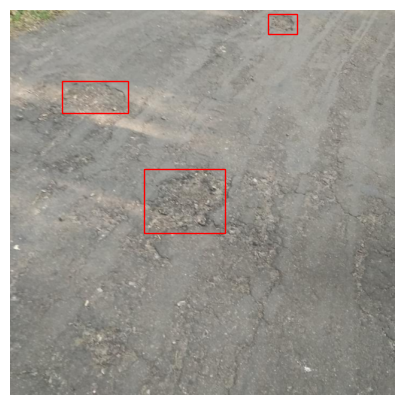

In [291]:
images,boxes = next(iter(train_loader))
plot_img_and_box([images[0].permute(1,2,0).numpy()],[boxes.tolist()[0][0]],linewidth=1)

In [ ]:
plot_img_and_box([img[0].permute(1,2,0).numpy()],[box.tolist()[0][0]],linewidth=1)

### Resize test

In [ ]:
img,box = next(iter(train_loader))
plot_img_and_box([img[0].permute(1,2,0).numpy()],[box.tolist()[0][0]])

In [ ]:
transform = transforms.Compose([transforms.Resize((512,512))])
new_width, new_height=512,512
_,_,o_h, o_w = img.shape
img_resized = transform(img)
x_scale = new_width / o_w
y_scale = new_height / o_h
scaled_bboxes = []
for bbox in box.tolist()[0][0]:
    x1, y1, x2, y2 = bbox
    scaled_bbox = [x1 * x_scale, y1 * y_scale, x2 * x_scale, y2 * y_scale]
    scaled_bboxes.append(scaled_bbox)
plot_img_and_box([img_resized[0].permute(1,2,0).numpy()],[scaled_bboxes])

In [ ]:
img,box=next(iter())

In [ ]:
boxes

### Selective Search

In [286]:
def extract_candidates(img):
    min_candidate_scale = 0.05
    max_candidate_scale = 1

    img_lbl, regions = selectivesearch.selective_search(img, scale=200, min_size=50)

    img_area = np.prod(img.shape[:2])
    candidates = []
    for r in regions:
        if r['rect'] in candidates: continue
        if r['size'] < (min_candidate_scale*img_area): continue
        if r['size'] > (max_candidate_scale*img_area): continue
        x1, y1, w, h = r['rect']
        x2 = w+x1
        y2 = h+y1
        candidates.append([x1,y1,x2,y2])
    return candidates    

ValueError: too many values to unpack (expected 4)

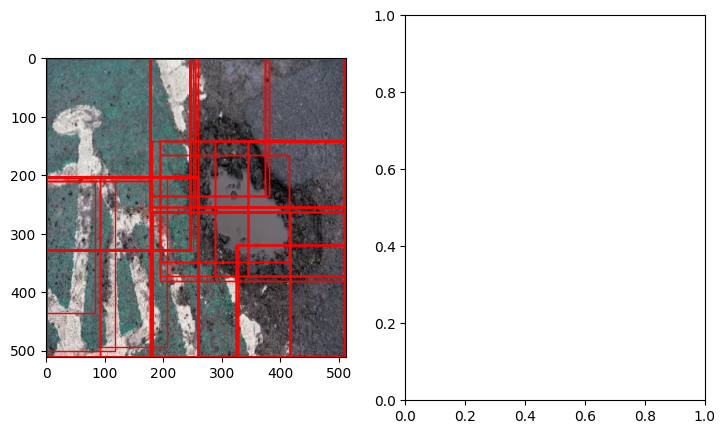

In [293]:
images,boxes = next(iter(train_loader))

img = images[0].permute(1,2,0)
candidates = extract_candidates(img)

plot_img_and_box([img,img],[candidates,candidates],gt=[boxes[0],boxes[0]],linewidth=1)

Specify the get_iou function that takes boxA and boxB as inputs where boxA and boxB are two different bounding boxes (you can consider boxA as the ground truth bounding box and boxB as the region proposal):

We define the epsilon parameter to address the rare scenario when the union between the two boxes is 0, resulting in a division by zero error. Note that in each of the bounding boxes, there will be four values corresponding to the four corners of the bounding box.

In [ ]:
def get_iou(boxA, boxB, epsilon=1e-5):
    x1 = max(boxA[0], boxB[0])
    y1 = max(boxA[1], boxB[1])
    x2 = min(boxA[2], boxB[2])
    y2 = min(boxA[3], boxB[3])
    width = (x2 - x1)
    height = (y2 - y1)
    if (width<0) or (height <0):
        return 0.0
    area_overlap = width * height
    area_a = (boxA[2] - boxA[0]) * (boxA[3] - boxA[1])
    area_b = (boxB[2] - boxB[0]) * (boxB[3] - boxB[1])
    area_combined = area_a + area_b - area_overlap
    iou = area_overlap / (area_combined+epsilon)
    return iou
     